##Aluna: Andréa Fonseca

# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil

Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [1]:
! pip install Pillow

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision

## Carregamento dos dados do MNIST

In [3]:
! git clone https://github.com/vcasadei/MNIST.git

Cloning into 'MNIST'...
remote: Enumerating objects: 10, done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 10
Receiving objects: 100% (10/10), 11.01 MiB | 7.97 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (6/6), done.


In [4]:
!ls MNIST

processed  raw


In [5]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [6]:
x_train = x_train.float()

x_train = x_train / 255.

if True:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(-0.5, 232.5, 87.5, -0.5)

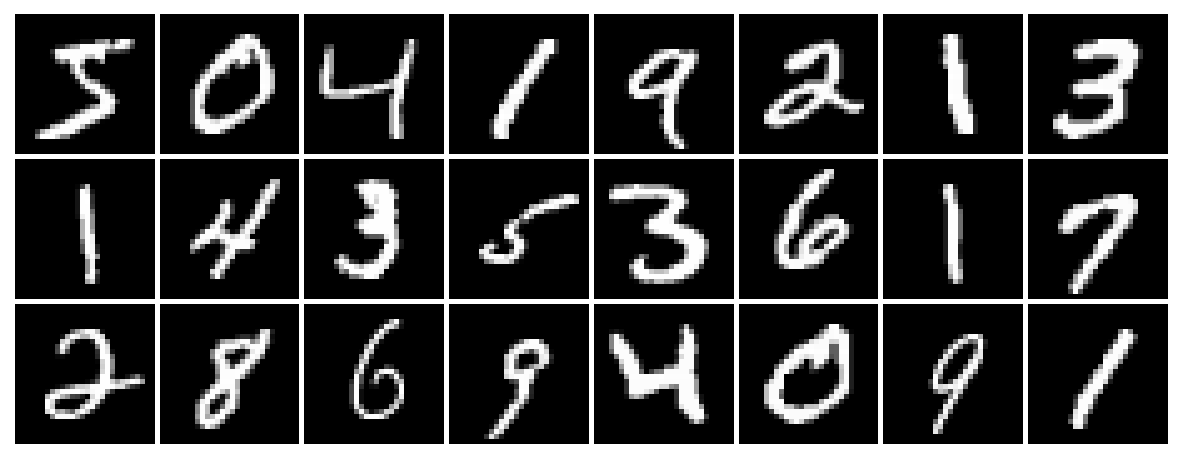

In [7]:
n_samples = 24

# cria um grid com as imagens na qtde definida de amostra
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(dim=1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


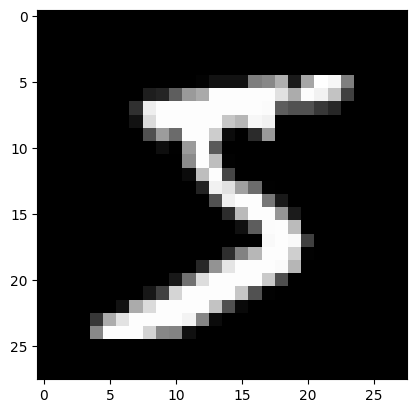

In [8]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy(), cmap='gray')
print('class:', target)

## Modelo

In [32]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

28 * 28 = 754 entradas

28 * 28 * 10 + 10 = 7850 parâmetros

10 saidas

### Testando um predict com poucas amostras

In [33]:
xin = x_train[:5].view(-1,28*28)
score = model(Variable(xin))
score

tensor([[ 8.8105e-02,  9.8109e-02,  2.2509e-01,  7.9293e-02,  3.2134e-02,
          1.3251e-02,  3.7184e-01,  2.2448e-01,  4.0557e-02, -5.1099e-01],
        [-2.6408e-02,  2.3709e-02,  4.5366e-02,  2.2090e-04, -2.1526e-01,
          2.2039e-01,  2.9647e-01,  3.9810e-02,  1.5692e-01, -3.7761e-01],
        [-9.0793e-02, -1.3169e-01, -6.4639e-02, -3.2243e-02,  5.1015e-02,
          2.0359e-01,  5.6703e-05,  5.6185e-02,  2.3688e-01, -1.9484e-01],
        [ 1.0503e-01,  1.9822e-01,  2.2338e-02, -4.0250e-01, -5.2509e-02,
          2.4839e-02, -9.3922e-02, -6.7656e-03,  2.7308e-01, -1.0604e-01],
        [-4.6855e-03, -1.4944e-01, -1.0660e-01, -9.7379e-02,  8.1629e-02,
          2.7347e-01,  3.1532e-02, -8.5801e-02,  3.1075e-01,  1.5159e-01]],
       grad_fn=<AddmmBackward0>)

Transformando em probabilidade

In [34]:
import torch.nn.functional as F
F.softmax(score, dim=1)*100

tensor([[10.0014, 10.1020, 11.4697,  9.9136,  9.4570,  9.2801, 13.2826, 11.4627,
          9.5370,  5.4938],
        [ 9.4204,  9.9046, 10.1214,  9.6747,  7.7993, 12.0574, 13.0105, 10.0654,
         11.3159,  6.6305],
        [ 9.0222,  8.6607,  9.2613,  9.5663, 10.3968, 12.1105,  9.8803, 10.4507,
         12.5204,  8.1307],
        [10.9842, 12.0570, 10.1124,  6.6122,  9.3832, 10.1377,  9.0025,  9.8224,
         12.9942,  8.8940],
        [ 9.4432,  8.1706,  8.5282,  8.6072, 10.2945, 12.4716,  9.7915,  8.7074,
         12.9453, 11.0405]], grad_fn=<MulBackward0>)

## Treinamento

### Inicialização dos parâmetros

In [35]:
epochs = 100
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [13]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-1_9_zzg7
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-1_9_zzg7
  Resolved https://github.com/szagoruyko/pytorchviz to commit 0adcd83af8aa7ab36d6afd139cabbd9df598edb7
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.10

In [36]:
from torchviz import make_dot, make_dot_from_trace
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
loss


tensor(2.3015, grad_fn=<NllLossBackward0>)

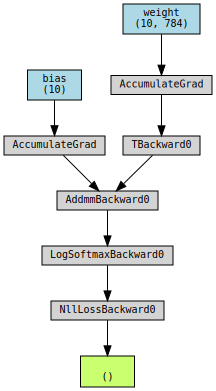

In [37]:
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

In [38]:
import numpy
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()


In [39]:
print('Final loss:', loss.item())

Final loss: 0.263967901468277


### Visualizando gráfico de perda durante o treinamento

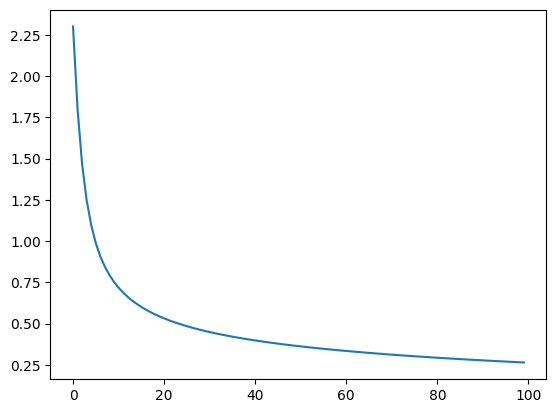

In [40]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [41]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean() # compara o pred com o train
print('Accuracy:', accuracy)

Accuracy: 0.943


Ainda que 94% seja alta, não é tão alta para o problema em tela.
Porque os rabiscos precisam ser separados e esse valor pode não permitir isso. O ideal seria 98%, 99%.

### Matriz de confusão com dados de treinamento e teste

In [42]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,96,0,1,0,0,0,1,0,0,2
1,0,110,1,0,0,0,2,2,1,0
2,0,1,91,1,0,1,0,1,1,1
3,0,0,0,88,0,2,0,0,0,0
4,0,0,1,0,102,2,1,2,0,3
5,0,2,0,1,0,82,0,0,2,1
6,1,0,1,1,2,2,90,0,0,0
7,0,1,1,1,0,0,0,111,0,3
8,0,2,2,0,0,1,0,0,83,0


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

Quanto mais claro, a rede deixa passar. Quanto mais escuro, não deixa passar.
Representação visual dos pesos que funcionam como filtros.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


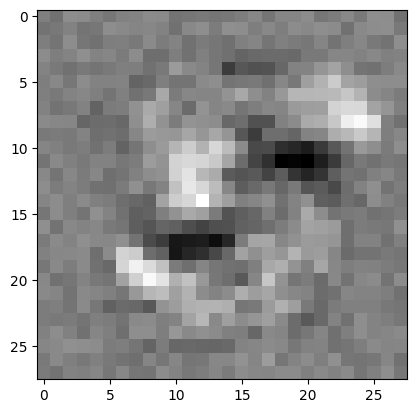

In [43]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 5
plt.imshow(weights[5, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

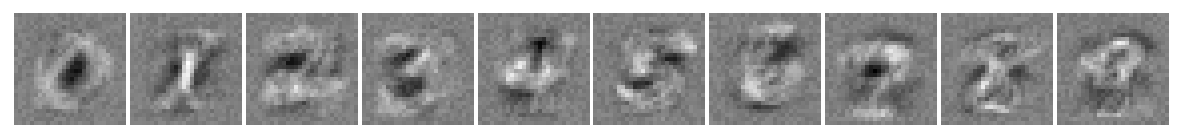

In [44]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

In [45]:
import numpy
losses = []
zs = [] # vetor de scores

for i in range(epochs):

    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1) # pega os predicts para calcular a acurácia da rede

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()

    print('Época: {}, Perda: {:.6f}, Acurácia: {:.6f}'
              .format(i + 1, loss, accuracy))

Época: 1, Perda: 0.262643, Acurácia: 0.943000
Época: 2, Perda: 0.261333, Acurácia: 0.944000
Época: 3, Perda: 0.260040, Acurácia: 0.945000
Época: 4, Perda: 0.258761, Acurácia: 0.945000
Época: 5, Perda: 0.257497, Acurácia: 0.946000
Época: 6, Perda: 0.256247, Acurácia: 0.946000
Época: 7, Perda: 0.255011, Acurácia: 0.946000
Época: 8, Perda: 0.253790, Acurácia: 0.946000
Época: 9, Perda: 0.252582, Acurácia: 0.947000
Época: 10, Perda: 0.251387, Acurácia: 0.947000
Época: 11, Perda: 0.250205, Acurácia: 0.947000
Época: 12, Perda: 0.249036, Acurácia: 0.947000
Época: 13, Perda: 0.247879, Acurácia: 0.947000
Época: 14, Perda: 0.246735, Acurácia: 0.947000
Época: 15, Perda: 0.245603, Acurácia: 0.947000
Época: 16, Perda: 0.244482, Acurácia: 0.949000
Época: 17, Perda: 0.243373, Acurácia: 0.949000
Época: 18, Perda: 0.242275, Acurácia: 0.949000
Época: 19, Perda: 0.241189, Acurácia: 0.949000
Época: 20, Perda: 0.240113, Acurácia: 0.949000
Época: 21, Perda: 0.239048, Acurácia: 0.949000
Época: 22, Perda: 0.23

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.


Época: 1, Perda: 0.161138, Acurácia: 0.971000

Época: 2, Perda: 0.160662, Acurácia: 0.971000

Época: 3, Perda: 0.160190, Acurácia: 0.971000

Época: 4, Perda: 0.159720, Acurácia: 0.971000

Época: 5, Perda: 0.159253, Acurácia: 0.971000

Época: 6, Perda: 0.158788, Acurácia: 0.971000

Época: 7, Perda: 0.158326, Acurácia: 0.971000

Época: 8, Perda: 0.157866, Acurácia: 0.971000

Época: 9, Perda: 0.157409, Acurácia: 0.972000

Época: 10, Perda: 0.156954, Acurácia: 0.972000

Época: 11, Perda: 0.156502, Acurácia: 0.972000

Época: 12, Perda: 0.156052, Acurácia: 0.972000

Época: 13, Perda: 0.155604, Acurácia: 0.973000

Época: 14, Perda: 0.155159, Acurácia: 0.973000

Época: 15, Perda: 0.154716, Acurácia: 0.973000

Época: 16, Perda: 0.154275, Acurácia: 0.973000

Época: 17, Perda: 0.153837, Acurácia: 0.973000

Época: 18, Perda: 0.153401, Acurácia: 0.973000

Época: 19, Perda: 0.152968, Acurácia: 0.973000

Época: 20, Perda: 0.152536, Acurácia: 0.973000

Época: 21, Perda: 0.152107, Acurácia: 0.973000



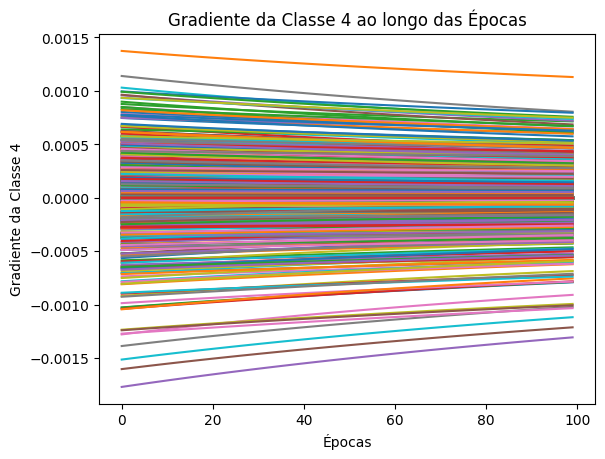

In [49]:
import numpy
losses = []
zs = [] # vetor de scores
gradientes_4 = []

for i in range(epochs):

    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()

    for name, param in model.named_parameters():
        if name == 'weight':
            gradientes_4.append(param.grad[4].detach().numpy())

    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1) # pega os predicts para calcular a acurácia da rede

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()

    print('\nÉpoca: {}, Perda: {:.6f}, Acurácia: {:.6f}'
              .format(i + 1, loss, accuracy))

plt.plot(gradientes_4)
plt.xlabel('Épocas')
plt.ylabel('Gradiente da Classe 4')
plt.title('Gradiente da Classe 4 ao longo das Épocas')
plt.show()

<details>
<summary>Mostrar Resultado</summary>

```python
losses = []
import numpy

import numpy
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)
    
    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    
    _, predicts = torch.max(outputs, 1)
    
    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    
    print('Epoch[{}/{}], loss: {:.6f}, acc: {:.6f}'
              .format(i+1, epochs, loss.data, accuracy))
    
    weights = model.state_dict()['weight']
    print('weights:', weights.shape)

    bias = model.state_dict()['bias']
    print('bias:   ', bias.shape)

    # Visualizando pesos da classe 3
    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()
```

</details>

## Perguntas

1. Qual é o shape da matriz de entrada na rede?
(1000, 28, 28)

2. Qual é o shape da saída da rede?
(1000, 10)

3. Qual é o número total de parâmetros da rede, incluindo o bias?
7850

# Aprendizados
